In [ ]:
# File: deepfake_detection_transfer_learning
# Name: Yu-Ju Fang 
"""
This dataset consists of about 4k REAL faces from the Flickr dataset collected by Nvidia, 
as well as 4k fake faces sampled from the 1 Million FAKE faces (generated by StyleGAN) 
that was provided by Bojan.

By using data augentation, Transfer Learing(Resnet) to achieve about 98.5% accuracy of distinguishing 
whether the input image is real face or fake face generated by StyleGAN
"""

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
# Please enter the address of the file
FOLDERNAME = 'Colab\ Notebooks/Deepfake_detection'
assert FOLDERNAME is not None, "[!] Enter the foldername."

In [3]:
%cd drive/MyDrive/$FOLDERNAME
BATCH_SIZE = 64

/content/drive/MyDrive/Colab Notebooks/Deepfake_detection


In [4]:
# See if GPU is available
# To turn GPU on: Edit -> Notebook Setting -> GPU
import torch
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [5]:
# Calculate the mean/std for Training Dataset
# You will see the mean/std of your data at the end of this cell
"""
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torchvision.transforms as T

transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
training_set = dset.ImageFolder('train1/', transform=transform)
train_loader = DataLoader(training_set, batch_size=len(training_set))
images, labels = next(iter(train_loader))
mean = images.mean()
std = images.std()
"""

"\nimport torchvision.datasets as dset\nfrom torch.utils.data import DataLoader\nimport torchvision.transforms as T\n\ntransform = T.Compose([T.Resize((256, 256)), T.ToTensor()])\ntraining_set = dset.ImageFolder('train1/', transform=transform)\ntrain_loader = DataLoader(training_set, batch_size=len(training_set))\nimages, labels = next(iter(train_loader))\nmean = images.mean()\nstd = images.std()\n"

In [6]:
mean = torch.tensor(0.4451)
std = torch.tensor(0.2706)
# Data Pre-processing by PyTorch
import torchvision.transforms as T

In [7]:
transform = T.Compose([T.Resize((256, 256)), T.ToTensor(), T.RandomHorizontalFlip(), T.Normalize(mean=mean, std=std)])

In [8]:
%ls
# Load Your Data by PyTorch
import torchvision.datasets as dset

deepfake_detection.ipynb                    test/   train1/  valid1/
deepfake_detection_transfer_learning.ipynb  train/  valid/


In [9]:
train = dset.ImageFolder('train1/', transform = transform)
val = dset.ImageFolder('valid1/', transform = transform)

In [11]:
# Create Mini-batches by PyTorch
mini_trains = None
mini_vals = None
from torch.utils.data import DataLoader

In [12]:
mini_trains = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
mini_vals = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)

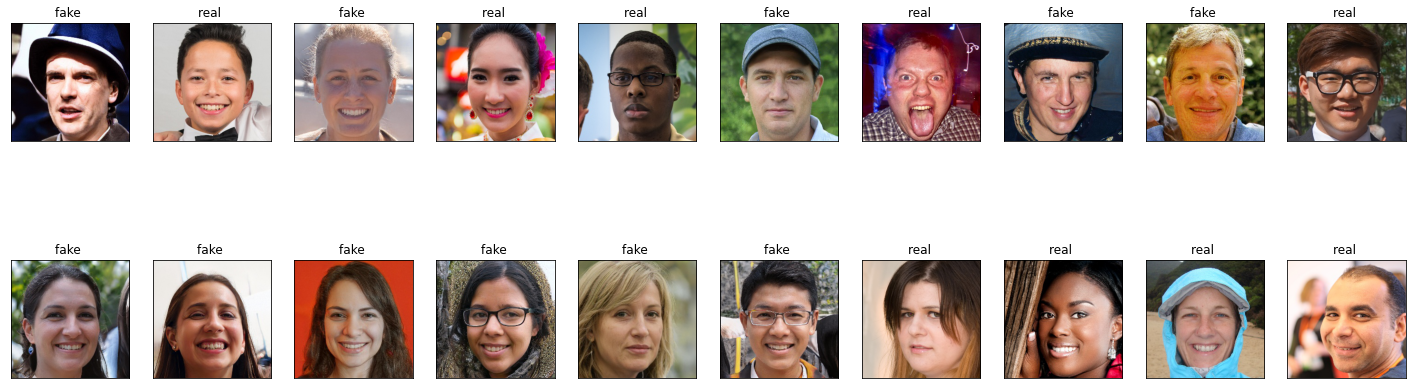

In [13]:
"""
Plot some training data! 
We need to denormalize PyTorch Tensor first, 
and then change it to images with RGB channel
"""

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
classes = ['fake','real']

# Reverse the normalized value to 0-255
def denormalize(image):
  image = T.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image

# Display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

dataiter = iter(mini_trains)
images, labels = dataiter.next()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))

In [14]:
import torch.nn as nn

In [15]:
from torchvision import models
import torch.optim as optim
resnet = models.resnet50(pretrained = True).cuda()
num_flatten = resnet.fc.in_features
resnet.fc = nn.Linear(num_flatten, 2)
model = resnet


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [17]:
from torchsummary import summary
summary(model.cuda(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
def evaluate_predictor(loader, model):
  # Turn on evaluation mode on your model
  model.eval()
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for x, y in loader:
      # move tensors to GPU if CUDA is available
      x = x.to(device)
      y = y.to(device)

      # forward pass: compute predicted outputs by passing inputs to the model
      scores = model(x)
      
      # Choose your loss function!
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(scores, y)

      val_loss += loss.item()*x.size(0)
      prediction = scores.data.max(1)[1]
      acc = prediction.eq(y).sum().item()
      val_acc += acc

    # calculate average losses
    val_loss = val_loss / len(mini_vals.dataset)
    val_acc = val_acc / len(mini_vals.dataset)
    print(f'Loss: {val_loss} / Acc: {val_acc}')
    

In [19]:
def train(model, optimizer, epochs=1):
  for epoch in range(epochs):
    print('----------------------------')
    print('EPOCH: {}'.format(epoch+1))
    for t, (x, y) in enumerate(mini_trains):  
      # Turn on the training mode on your model
      model.train()
      # move tensors to GPU if CUDA is available
      x = x.to(device)
      y = y.to(device)

      # forward pass: compute predicted outputs by passing inputs to the model
      scores = model(x)
      
      # calculate the batch loss
      # Choose your loss function!
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(scores, y)

      # clear the gradients of all optimized variables
      optimizer.zero_grad()

      loss.backward()

      # perform a single optimization step (parameter update)
      optimizer.step()

      if t % 7 == 0:
        print('Iteration %d, loss = %.4f' % (t, loss.item()))
        evaluate_predictor(mini_vals, model)

In [20]:
train(model, optimizer, epochs=10)

----------------------------
EPOCH: 1
Iteration 0, loss = 0.7005
Loss: 0.7091253563647962 / Acc: 0.5057251908396947
Iteration 7, loss = 0.6243
Loss: 0.6651789323064207 / Acc: 0.5801526717557252
Iteration 14, loss = 0.6170
Loss: 0.6105443298361684 / Acc: 0.6844783715012722
Iteration 21, loss = 0.5592
Loss: 0.5614981918237895 / Acc: 0.7430025445292621
Iteration 28, loss = 0.6342
Loss: 0.5235478354774359 / Acc: 0.7792620865139949
Iteration 35, loss = 0.4861
Loss: 0.4948426784601527 / Acc: 0.7926208651399491
Iteration 42, loss = 0.4659
Loss: 0.4706852772005338 / Acc: 0.7958015267175572
Iteration 49, loss = 0.4632
Loss: 0.4484364266765633 / Acc: 0.799618320610687
Iteration 56, loss = 0.3703
Loss: 0.4224681646465952 / Acc: 0.8174300254452926
Iteration 63, loss = 0.3779
Loss: 0.39033640993157115 / Acc: 0.8365139949109415
Iteration 70, loss = 0.3574
Loss: 0.3561825592250921 / Acc: 0.8543256997455471
Iteration 77, loss = 0.2842
Loss: 0.3303492440067175 / Acc: 0.8683206106870229
Iteration 84, lo